### We begin with boilerplate:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import HTML
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from copy import deepcopy

In [4]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# Covid epidemic simulator - illustrative Leeds example

In [5]:
from codit.disease import Covid
from codit.outbreak import Outbreak
from codit.outbreak_recorder import WardComponent
from codit.population.covid import PersonCovid
import codit.society as society
import codit.society.alternatives
import codit.config
from codit.immunity import ImmuneResponse

from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras

/home/paul/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


(access to real data on Leeds)

In [6]:
import pandas as pd
from codit import share_dir
DATA_PATH = share_dir() / 'codit' / 'data'
TIME_SERIES_WARDS = DATA_PATH / 'city' / 'population' / 'Timeseries_Leeds_wards.csv'

### Baseline config of the simulation

We want to set up Leeds in 2021, so:

In [7]:
CITY_OBSERVE = 'Leeds'
POP_SIZE = city_paras[CITY_OBSERVE]['population']
LOCKDOWN_LEVEL = 0.66   # proportion of classrooms and workplaces to close down for lockdown
COVID_VARIANT = ImmuneResponse.B_1_1_7_INFECTION

Here's some baseline config that is informing these simulations:

In [8]:
codit.config.print_baseline_config()

CROSS_IMMUNITY {<ImmuneResponse.SARS_CoV_2_INFECTION: 1>: {<ImmuneResponse.SARS_CoV_2_INFECTION: 1>: 1.0, <ImmuneResponse.B_1_1_7_INFECTION: 2>: 1.0, <ImmuneResponse.B_1_617_2_INFECTION: 4>: 1.0}, <ImmuneResponse.B_1_1_7_INFECTION: 2>: {<ImmuneResponse.SARS_CoV_2_INFECTION: 1>: 1.0, <ImmuneResponse.B_1_1_7_INFECTION: 2>: 1.0, <ImmuneResponse.B_1_617_2_INFECTION: 4>: 1.0}, <ImmuneResponse.B_1_617_2_INFECTION: 4>: {<ImmuneResponse.SARS_CoV_2_INFECTION: 1>: 1.0, <ImmuneResponse.B_1_1_7_INFECTION: 2>: 1.0, <ImmuneResponse.B_1_617_2_INFECTION: 4>: 1.0}}
DAILY_TEST_CAPACITY_PER_HEAD 0.0075
DAYS_BEFORE_INFECTIOUS 4
DAYS_INFECTIOUS_TO_SYMPTOMS 2
DAYS_OF_SYMPTOMS 5
DEFAULT_COVID ImmuneResponse.SARS_CoV_2_INFECTION
DURATION_OF_ISOLATION 10
MEAN_NETWORK_SIZE 9.0
PROB_APPLY_FOR_TEST_IF_SYMPTOMS 0.75
PROB_GET_TEST_IF_TRACED 0.75
PROB_INFECT_IF_TOGETHER_ON_A_DAY {<ImmuneResponse.SARS_CoV_2_INFECTION: 1>: 0.025, <ImmuneResponse.B_1_1_7_INFECTION: 2>: 0.039, <ImmuneResponse.B_1_617_2_INFECTION: 4>: 0.

We build a Leeds population:

In [9]:
pop = CityPopulation(POP_SIZE, society.Society(), person_type=PersonCovid, 
                     lockdown_config={'classrooms': LOCKDOWN_LEVEL, 'workplaces': LOCKDOWN_LEVEL})

2021-05-16 17:11:19,972 INFO:Building a set of 317255 households from which to build a population
2021-05-16 17:12:33,451 INFO:312181 households of mean size 2.54
2021-05-16 17:12:37,382 INFO:141784 buildings of mean size 5.59
2021-05-16 17:13:07,099 INFO:2041 classrooms of mean size 29.28
2021-05-16 17:13:07,429 INFO:116 care_homes of mean size 105.00
2021-05-16 17:13:08,261 INFO:93033 workplaces of mean size 5.63
2021-05-16 17:13:11,168 INFO:66.0% of workplaces closed by lockdown, leaving 33282 open, of average Income Decile 4.88 (and st dev 3.14).
2021-05-16 17:13:11,356 INFO:66.0% of classrooms closed by lockdown, leaving 734 open, of average Income Decile 4.24 (and st dev 3.02).
2021-05-16 17:13:11,383 INFO:Adding 346313 permanent contact groups
2021-05-16 17:13:11,487 INFO:Adding 39657 ephemeral contact pairs
2021-05-16 17:13:12,344 INFO:Adding 239601 contacts each within one of the 141784 buildings (contact density of 0.75)


Lets just check out the contact network a little more:

In [10]:
nets = [len(p.contacts) for p in pop.people]

print(f"""People typically come into physical contact with {np.median(nets):2.1f} people each day,
but on average {np.mean(nets):2.1f} people.
There are people seeing as many as {np.max(nets):2.0f} people each day""")

People typically come into physical contact with 4.0 people each day,
but on average 8.0 people.
There are people seeing as many as 146 people each day


### Finally ready to simulate:
We begin by seeding the simulation with Covid, and allowing this to spread for 21 days of 'burn-in' before beginning to report simulation results.

In [11]:
BURNIN_DAYS = 18
DAYS_MONTH = 30

In [12]:
WINTER_PREVALENCE = 1/50

We simulate a PCR policy from 2020 of test, trace, and isolate, but with better testing capacity. Contacts, however, are not tested themselves.

In [13]:
soc = society.alternatives.UKSociety(config=dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                                                 PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.33))

We use the 'Kent' variant of Covid:

In [14]:
disease = Covid(variant=COVID_VARIANT)

Combine these elements into our model, ready for simulation:

In [15]:
o_Jan_Feb = Outbreak(soc, disease, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)

We set up some additional reporting at the ward level:

In [16]:
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))

Lets 'burn-in' the disease:

In [17]:
o_burnin = Outbreak(soc, disease, n_days=BURNIN_DAYS, seed_size=int(POP_SIZE*WINTER_PREVALENCE),  population=pop)
o_burnin.simulate()

2021-05-16 17:14:12,918 INFO:Day 1, prop infected is 0.02, prop infectious is 0.0143
2021-05-16 17:15:42,289 INFO:Day 18, prop infected is 0.08, prop infectious is 0.0228


#### OK, now lets run a simulation:

In [18]:
o_Jan_Feb.simulate()

2021-05-16 17:15:47,686 INFO:Day 1, prop infected is 0.09, prop infectious is 0.0225
2021-05-16 17:20:07,100 INFO:Day 51, prop infected is 0.17, prop infectious is 0.0062
2021-05-16 17:20:43,595 INFO:Day 60, prop infected is 0.18, prop infectious is 0.0046


2021-05-16 17:20:45,227 INFO: Realized R0 of early infections is 0.99
2021-05-16 17:20:45,228 INFO: 17.8 percent of the population was infected during the epidemic


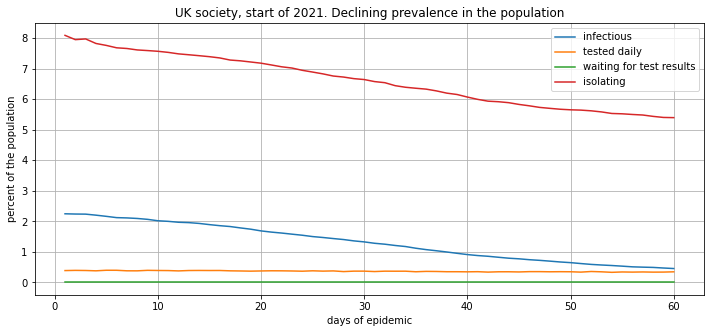

In [19]:
o_Jan_Feb.recorder.plot(title='UK society, start of 2021. Declining prevalence in the population')

In [20]:
ward_results = o_Jan_Feb.recorder.components[-1]

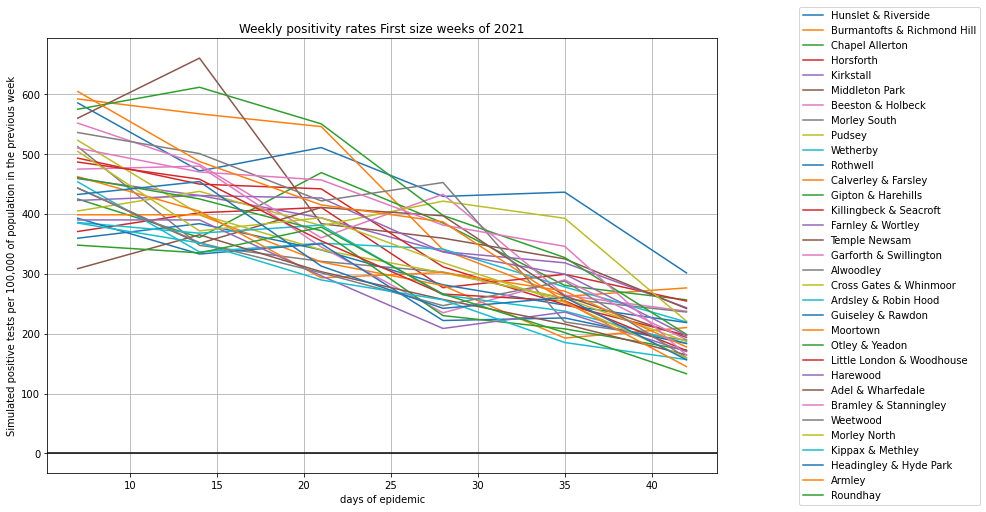

In [21]:
SIX_WEEKS = 5 * 7
ward_results.plot_weekly_positivity(SIX_WEEKS, title='First size weeks of 2021')

How does this stack up against the real ward-level data:

In [22]:
df_wards = pd.read_csv(TIME_SERIES_WARDS,index_col=0)

df_wards.drop(columns = [c for c in df_wards.columns if '2020' in c], inplace=True)
df_wards.drop(columns = df_wards.columns[-1:], inplace=True)  # here we remove the final datapoint which is < 1 week
df_wards.columns=[c[-10:] for c in df_wards.columns]

order = np.argsort(df_wards.iloc[:,-1:].values, axis=None) # get the order of the last column
df_wards = df_wards.iloc[np.flip(order)]     # sort the dataframe in decending order

FileNotFoundError: [Errno 2] No such file or directory: '/home/paul/CODiT/share/codit/data/city/population/Timeseries_Leeds_wards.csv'

In [ ]:
ax = df_wards.T.plot(title="In reality: detected Covid - first six weeks of 2021", 
                              figsize=(12,8), grid=True)
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
ax.set_ylabel("Real positive tests per 100,000 of population in the previous week")
_ = ax.axhline(600, color='k')

In [23]:
for p in pop.people:
    # We remove history:
    p.infector = None

### Lets press on ...

In [24]:
from codit.society.lateral import LateralFlowUK

In [25]:
for p in pop.people:
    # stop recursion ...
    p.infector = None

In [26]:
soc_March_April = soc #LateralFlowUK(config=dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
              #                     PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.4))

In [27]:
pop.set_structure(soc_March_April, lockdown_config={'classrooms': 0, 'workplaces': 0.66})

2021-05-16 17:25:21,198 INFO:66.0% of workplaces closed by lockdown, leaving 33281 open, of average Income Decile 4.90 (and st dev 3.14).
2021-05-16 17:25:21,474 INFO:0% of classrooms closed by lockdown, leaving 1685 open, of average Income Decile 4.77 (and st dev 3.08).
2021-05-16 17:25:21,509 INFO:Adding 347263 permanent contact groups
2021-05-16 17:25:21,650 INFO:Adding 39657 ephemeral contact pairs
2021-05-16 17:25:22,573 INFO:Adding 239531 contacts each within one of the 141784 buildings (contact density of 0.75)


Combine these elements into our model, ready for simulation:

In [28]:
o_March_April = Outbreak(soc_March_April, disease, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)

We set up some additional reporting at the ward level:

In [29]:
o_March_April.recorder.add_component(WardComponent(o_March_April))

#### Vaccinations to date:

In [30]:
for p in pop.people:
    if p.age > 60:
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

### Lets fast-forward through March and April:

In [31]:
o_March_April.simulate()

2021-05-16 17:26:04,803 INFO:Day 1, prop infected is 0.18, prop infectious is 0.0043
2021-05-16 17:29:09,145 INFO:Day 51, prop infected is 0.20, prop infectious is 0.0029
2021-05-16 17:29:41,688 INFO:Day 60, prop infected is 0.20, prop infectious is 0.0027


2021-05-16 17:29:44,740 INFO: Realized R0 of early infections is 0.99
2021-05-16 17:29:44,741 INFO: 20.4 percent of the population was infected during the epidemic


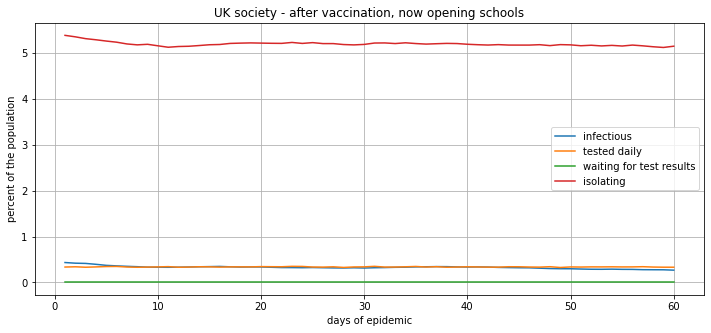

In [32]:
o_March_April.recorder.plot(title='UK society - after vaccination, now opening schools')

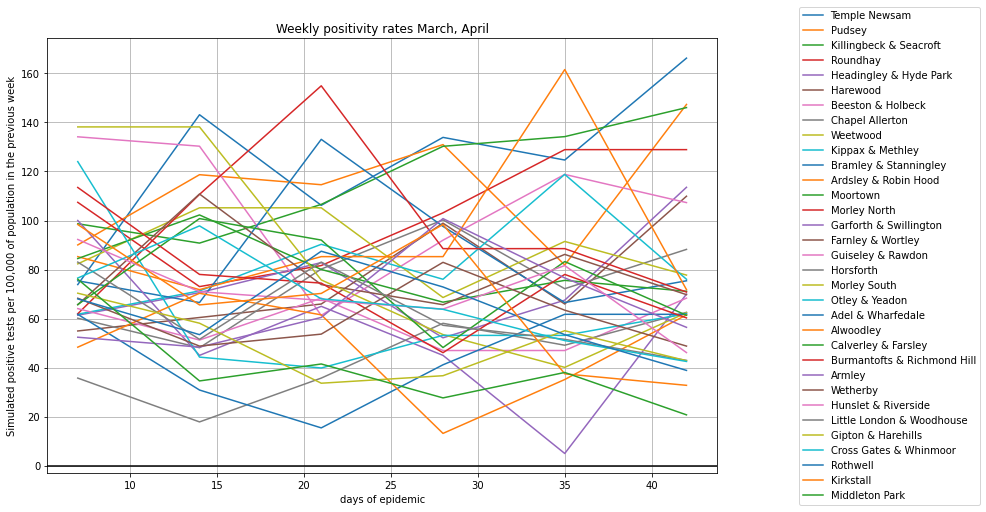

In [33]:
o_March_April.recorder.components[-1].plot_weekly_positivity(SIX_WEEKS, title='March, April')

In [34]:
guy = pop.people[100]

In [35]:
guy.home.lsoa.features

{'lsoa11nm': 'Leeds 063B',
 'population': 4743,
 'msoa11cd': 'E02002392',
 'msoa11nm': 'Leeds 063',
 'lad17cd': 'E08000035',
 'lad17nm': 'Leeds',
 'IMD_Rank': 14758.0,
 'IMD_Decile': 5.0,
 'IMD_Score': 19.558,
 'Income_Rank': 29709.0,
 'Income_Decile': 10.0,
 'Income_Score': 0.035,
 'Employment_Rank': 32015.0,
 'Employment_Decile': 10.0,
 'Employment_Score': 0.022,
 'Education_Rank': 25785.0,
 'Education_Decile': 8.0,
 'Education_Score': 6.347,
 'Health_Rank': 3630.0,
 'Health_Decile': 2.0,
 'Health_Score': 1.087,
 'Crime_Rank': 13097.0,
 'Crime_Decile': 4.0,
 'Crime_Score': 0.226,
 'Housing_Rank': 23314.0,
 'Housing_Decile': 8.0,
 'Housing_Score': 14.783,
 'LivingEnv_Rank': 67.0,
 'LivingEnv_Decile': 1.0,
 'LivingEnv_Score': 71.851,
 'IDACI_Rank': 6138.0,
 'IDACI_Decile': 2.0,
 'IDACI_Score': 0.264,
 'IDAOPI_Rank': 5077.0,
 'IDAOPI_Decile': 2.0,
 'IDAOPI_Score': 0.29}

In [36]:
guy.home.type

'apartments'

In [37]:
{p for p in pop.people if p.home == guy.home}

{person 100, person 101, person 99}

In [38]:
guy.age

50

In [39]:
two_weeks_real = df_wards.T.loc['04/02/2021':].mean()
two_weeks_sim = ward_results.dataframe(ward_results.positive_tests)[35:35 + 14].mean() * 100000
df_merge = pd.concat([two_weeks_real.rename('real'), two_weeks_sim.rename('sim')], axis=1)

NameError: name 'df_wards' is not defined

In [ ]:
plt.rcParams["figure.figsize"] = [12, 8]
ax = df_merge.plot.scatter(x='real', y='sim', grid=True)
ax.axline([100, 100],[300, 300])
for i, ward in df_merge.iterrows():
    ax.annotate(i, (ward['real'], ward['sim']), size=10, xytext=(0,0), ha='right', textcoords='offset points')

In [ ]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(df_merge['real'][:, None], df_merge['sim'][:, None])

In [ ]:
reg.coef_

In [ ]:
reg.score(df_merge['real'][:, None], df_merge['sim'][:, None])

In [ ]:
df_merge